## Learning Tensorflow From Scratch - CNN

https://github.com/wagonhelm/Visualizing-Convnets/blob/master/visualizingConvnets.ipynb

In [1]:
import tensorflow as tf
import scipy.ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt
import numpy as np

import imFunctions as imf

%matplotlib inline

In [2]:
# create a test set with 15% of the data as the test set.
imf.sortImages(0.15)

Images allready sorted


In [3]:
train_x, train_y, test_x, test_y, classes, classLabels = imf.buildDataset()

samoyed = [[ 1.  0.]]
shibainu = [[ 0.  1.]]
Total Train Size: 340  Total Test Size: 60  Total # Classes 2


In [4]:
image = train_x[202]
#plt.imshow(image.reshape(224,224,3))

In [5]:
# set up some tf vars:
X = tf.placeholder(tf.float32, shape=(None, 224, 224, 3))
Y_ = tf.placeholder(tf.float32, [None, classes])
keepRate1 = tf.placeholder(tf.float32)
keepRate2 = tf.placeholder(tf.float32)

In [6]:
# CONVOLUTION 1 - 1
with tf.name_scope('conv1_1'):
    filter1_1 = tf.Variable(tf.truncated_normal([3, 3, 3, 32], dtype=tf.float32,
                            stddev=1e-1), name='weights1_1')
    stride = [1,1,1,1]
    conv = tf.nn.conv2d(X, filter1_1, stride, padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_1')
    out = tf.nn.bias_add(conv, biases)
    conv1_1 = tf.nn.relu(out)

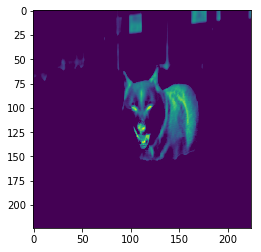

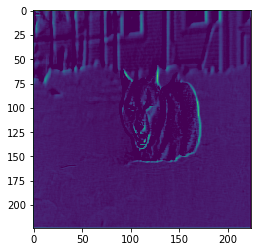

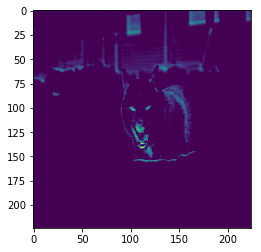

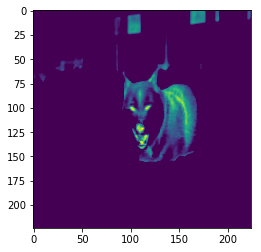

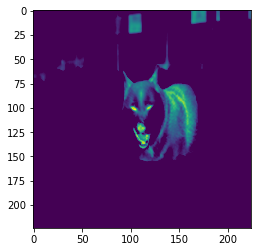

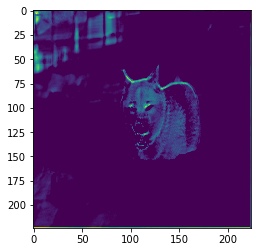

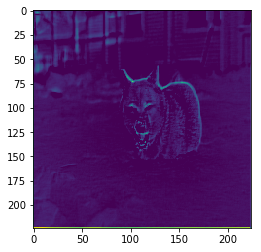

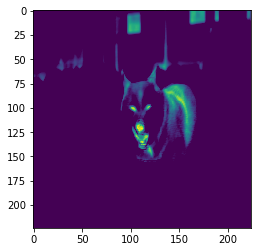

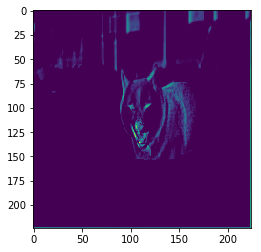

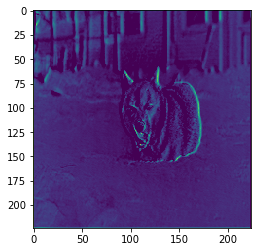

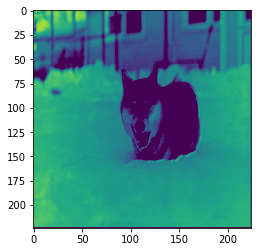

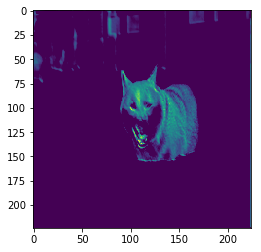

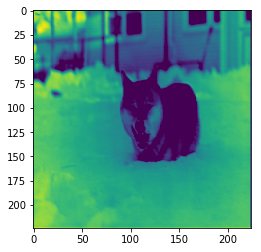

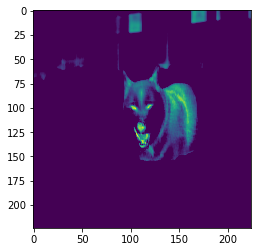

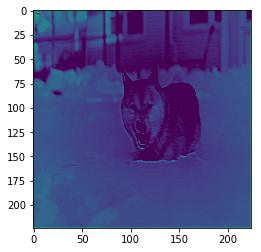

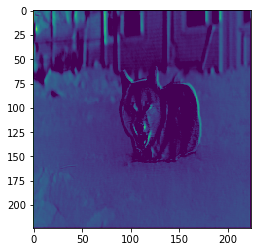

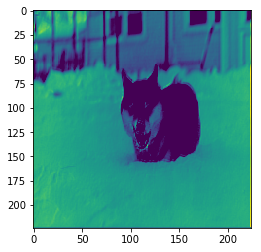

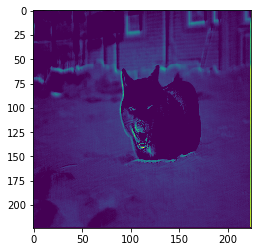

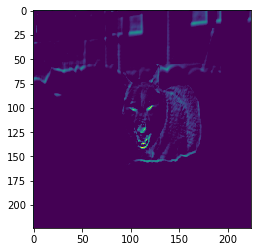

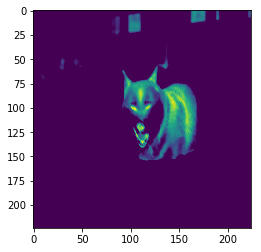

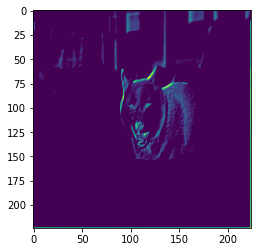

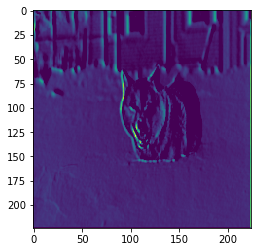

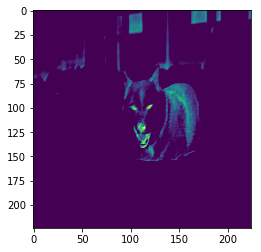

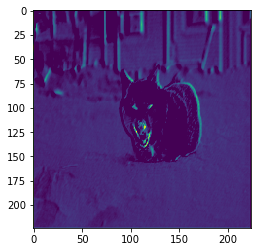

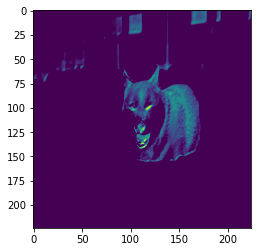

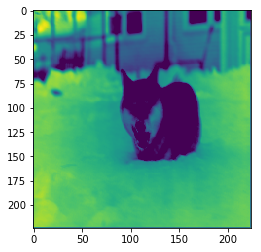

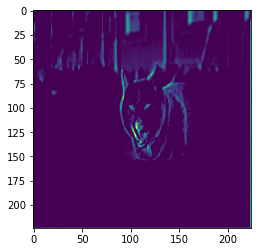

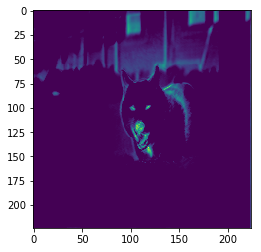

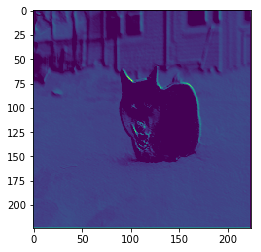

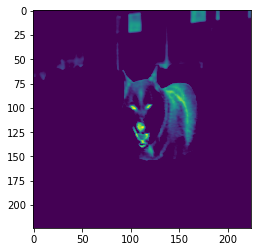

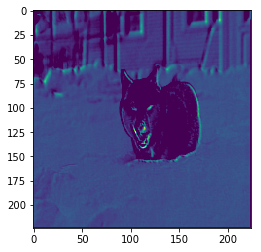

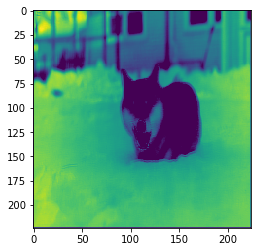

In [8]:
test = tf.Session()

test.run(tf.global_variables_initializer())
filteredImage = test.run(conv1_1, feed_dict={X: image.reshape(1,224,224,3)})
for i in range(32):
    plt.imshow(filteredImage[:,:,:,i].reshape(224,224))
    plt.show()

In [9]:
# CONVOLUTION 1 - 2
with tf.name_scope('conv1_2'):
    filter1_2 = tf.Variable(tf.truncated_normal([3, 3, 32, 32], dtype=tf.float32,
                                                stddev=1e-1), name='weights1_2')
    conv = tf.nn.conv2d(conv1_1, filter1_2, [1,1,1,1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[32], dtype=tf.float32),
                         trainable=True, name='biases1_2')
    out = tf.nn.bias_add(conv, biases)
    conv1_2 = tf.nn.relu(out)

In [10]:
# POOL 1
with tf.name_scope('pool1'):
    pool1_1 = tf.nn.max_pool(conv1_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool1_1')
    pool1_1_drop = tf.nn.dropout(pool1_1, keepRate1)

In [11]:
# CONVOLUTION 2 - 1
with tf.name_scope('conv2_1'):
    filter2_1 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_1')
    conv = tf.nn.conv2d(pool1_1_drop, filter2_1, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_1')
    out = tf.nn.bias_add(conv, biases)
    conv2_1 = tf.nn.relu(out)
    
# CONVOLUTION 2 - 2
with tf.name_scope('conv2_2'):
    filter2_2 = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_2')
    conv = tf.nn.conv2d(conv2_1, filter2_2, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_2')
    out = tf.nn.bias_add(conv, biases)
    conv2_2 = tf.nn.relu(out)
    
# POOL 2
with tf.name_scope('pool2'):
    pool2_1 = tf.nn.max_pool(conv2_2,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             name='pool2_1')
    pool2_1_drop = tf.nn.dropout(pool2_1, keepRate1)

In [14]:
#FULLY CONNECTED 1
with tf.name_scope('fc1') as scope:
    shape = int(np.prod(pool2_1_drop.get_shape()[1:]))
    fc1w = tf.Variable(tf.truncated_normal([shape, 512], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_1')
    fc1b = tf.Variable(tf.constant(1.0, shape=[512], dtype=tf.float32),
                       trainable=True, name='biases3_1')
    pool2_flat = tf.reshape(pool2_1_drop, [-1, shape])
    out = tf.nn.bias_add(tf.matmul(pool2_flat, fc1w), fc1b)
    fc1 = tf.nn.relu(out)
    fc1_drop = tf.nn.dropout(fc1, keepRate2)

In [15]:
#FULLY CONNECTED 3 & SOFTMAX OUTPUT
with tf.name_scope('softmax') as scope:
    fc2w = tf.Variable(tf.truncated_normal([512, classes], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_2')
    fc2b = tf.Variable(tf.constant(1.0, shape=[classes], dtype=tf.float32),
                       trainable=True, name='biases3_2')
    Ylogits = tf.nn.bias_add(tf.matmul(fc1_drop, fc2w), fc2b)
    Y = tf.nn.softmax(Ylogits)

In [16]:
numEpochs = 40
batchSize = 10
alpha = 1e-5


with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    loss = tf.reduce_mean(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)

In [17]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
writer_1 = tf.summary.FileWriter("/tmp/cnn/train")
writer_2 = tf.summary.FileWriter("/tmp/cnn/test")
writer_1.add_graph(sess.graph)
tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
tf.summary.histogram("weights1_1", filter1_1)
write_op = tf.summary.merge_all()

In [ ]:
steps = int(train_x.shape[0]/batchSize)

for i in range(numEpochs):
    accHist = []
    accHist2 = []
    train_x, train_y = imf.shuffle(train_x, train_y)
    for ii in range(steps):
        #Calculate our current step
        step = i * steps + ii
        #Feed forward batch of train images into graph and log accuracy
        acc = sess.run([accuracy], feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist.append(acc)
        
        if step % 5 == 0:
            # Get Train Summary for one batch and add summary to TensorBoard
            summary = sess.run(write_op, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
            writer_1.add_summary(summary, step)
            writer_1.flush()
            
            # Get Test Summary on random 10 test images and add summary to TensorBoard
            test_x, test_y = imf.shuffle(test_x, test_y)
            summary = sess.run(write_op, feed_dict={X: test_x[0:10,:,:,:], Y_: test_y[0:10], keepRate1: 1, keepRate2: 1})
            writer_2.add_summary(summary, step)
            writer_2.flush()

        #Back propigate using adam optimizer to update weights and biases.
        sess.run(train_step, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], keepRate1: 0.2, keepRate2: 0.5})
    
    print('Epoch number {} Training Accuracy: {}'.format(i+1, np.mean(accHist)))
    
    #Feed forward all test images into graph and log accuracy
    for iii in range(int(test_x.shape[0]/batchSize)):
        acc = sess.run(accuracy, feed_dict={X: test_x[(iii*batchSize):((iii+1)*batchSize),:,:,:], Y_: test_y[(iii*batchSize):((iii+1)*batchSize)], keepRate1: 1, keepRate2: 1})
        accHist2.append(acc)
    print("Test Set Accuracy: {}".format(np.mean(accHist2)))

Epoch number 1 Training Accuracy: 0.4882352948188782
Test Set Accuracy: 0.4833333492279053
Epoch number 2 Training Accuracy: 0.5235294699668884
Test Set Accuracy: 0.4500000476837158
Epoch number 3 Training Accuracy: 0.5352940559387207
Test Set Accuracy: 0.5333333611488342
Epoch number 4 Training Accuracy: 0.550000011920929
Test Set Accuracy: 0.4833333194255829
Epoch number 5 Training Accuracy: 0.5205882787704468
Test Set Accuracy: 0.5666667222976685
Epoch number 6 Training Accuracy: 0.529411792755127
Test Set Accuracy: 0.5666666626930237
Epoch number 7 Training Accuracy: 0.5235294699668884
Test Set Accuracy: 0.5833333134651184


In [ ]:
sess.close()